# LDA
- Brigitte Hogan (bwh5v@virginia.edu) & Jason Tiezzi (jbt5am@virginia.edu)  
- DS 5001  
- April 2020  
---
Create a topic model from our corpus  using SciKit Learn's library.

# Setup

## Import

#### LDA

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer          # CountVectorizer creates document term matrix, doesn't do POS
from sklearn.decomposition import LatentDirichletAllocation as LDA
import os

In [2]:
%matplotlib inline

In [3]:
# For LDA Visualization
import plotly_express as px # comment & clear output below to return Jupyter Lab buttons
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

#### Clustering

In [4]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

## Configs

In [5]:
#data_dir = '../../Notebooks/Homework/Homework08_LDA/data/' # Homework example
data_dir = 'Tables/' # Cookbook

In [6]:
n_terms  = 5000 # trying more words, original was 4000
n_topics = 25  # tried fewer, didn't help
max_iter = 5

#OHCO = ['book_id', 'chap_num', 'para_num'] # homework example
OHCO_full = ['book_id', 'vol_num', 'chap_num', 'recp_num', 'para_num', 'sent_num', 'token_num'] # full cookbook OHCO
OHCO = ['book_id', 'recp_num', 'para_num'] # LDA Cookbook OHCO (drop volume & chapter)

## Define Functions

In [7]:
def plot_tree(PHI, GROUP, metric = 'euclidean', method = 'ward'):
    
    # Get variables
    SIMS = pdist(normalize(PHI), metric=metric)
    TREE = sch.linkage(SIMS, method=method)
    labels  = ["{}: {}".format(a,b) for a, b in zip(GROUP.index, GROUP.topterms.tolist())]
    
    # Plots dendrogram of topics
    plt.figure();
    fig, axes = plt.subplots(figsize=(5, 10));
    dendrogram = sch.dendrogram(TREE, labels=labels, orientation="left");
    plt.tick_params(axis='both', which='major', labelsize=14);

In [8]:
def getTopics(PHI, THETA):
    TOPICS = PHI.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)
    TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ' '.join(x), 1) # add label column
    TOPICS['doc_weight_sum'] = THETA.sum()
    return TOPICS

In [9]:
def get_Authors(THETA, LIB, OHCO, TOPICS, n_topics = 30, author_name = 'author'):
    topic_cols = [t for t in range(n_topics)]
    AUTHORS = THETA.join(LIB, on='book_id')\
        .reset_index().set_index([author_name]+OHCO)\
        .groupby(author_name)[topic_cols].mean()\
        .T                                            
    AUTHORS.index.name = 'topic_id'
    AUTHORS['topterms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)
    return AUTHORS

In [10]:
def get_Group(THETA, LIB, OHCO, TOPICS, n_topics = 30, name = 'author'):
    topic_cols = [t for t in range(n_topics)]
    GROUPS = THETA.join(LIB, on='book_id')\
        .reset_index().set_index([name]+OHCO)\
        .groupby(name)[topic_cols].mean()\
        .T                                            
    GROUPS.index.name = 'topic_id'
    GROUPS['topterms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)
    return GROUPS

---
# Prepare Data

## Read in files

#### Create 'TOKEN2.csv' (optional; if not done in BOW/TFIDF)

In [11]:
if os.path.exists(data_dir + 'TOKEN2.csv') == False:
    #
    # read in tables
    TOKEN = pd.read_csv(data_dir + 'TOKEN.csv').set_index(OHCO_full)
    VOCAB = pd.read_csv(data_dir + 'VOCAB.csv')
    #
    # adjust TOKEN table to match VOCAB
    TOKEN = TOKEN[~TOKEN.term_str.isna()]
    #
    # Add term_id to TOKEN to cobmine VOCAB & TOKEN tables later
    TOKEN['term_id'] = TOKEN.term_str.map(VOCAB.reset_index().set_index('term_str').term_id) # using .map() because no shared index yet
    TOKEN.to_csv(data_dir + 'TOKEN2.csv')
    #
    print('Created TOKEN2.csv in' + data_dir)

In [12]:
TOKENS = pd.read_csv(data_dir + 'TOKEN2.csv') # Cookbooks

In [13]:
LIB = pd.read_csv(data_dir + 'LIB.csv').set_index('book_id')

## Convert TOKENs to Table of Paragraphs

Scikit Learn wants an F1 style corpus. We create onefrom our annotated TOKEN table, keeping only regular nouns.  
*going backwards now, reform strings*

In [14]:
TOKENS.head()

book_id  vol_num  chap_num  recp_num  para_num  sent_num  token_num  \
0     9935        1         1       1.0         0         0          0   
1     9935        1         1       1.0         0         1          0   
2     9935        1         1       1.0         0         1          1   
3     9935        1         1       1.0         0         1          3   
4     9935        1         1       1.0         0         1          4   

             pos_tuple  pos token_str  term_str  term_id  
0          ('1', 'CD')   CD         1         1       14  
1    ('Without', 'IN')   IN   Without   without    16577  
2      ('doubt', 'NN')   NN     doubt     doubt     5252  
3        ('the', 'DT')   DT       the       the    15108  
4  ('greatest', 'JJS')  JJS  greatest  greatest     7253

*taking nouns with a possible 's' at the end*

In [15]:
PARAS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(OHCO).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'para_str'})

In [16]:
PARAS.head()

para_str
book_id recp_num para_num                                                   
9935    1.0      0         doubt problem race food order person life body...
        2.0      0         principles cooking food refers preparation foo...
        3.0      0         providing food home matter lot housewife fact ...
        4.0      0         factor problem food housewife distinction wast...
                 1         connection problem waste leakage household cau...

## Create Vector Space

We use Scikit Learn's CountVectorizer to convert our F1 corpus of paragraphs into a document-term vector space of word counts.

In [17]:
tfv = CountVectorizer(max_features=n_terms, stop_words='english')
tf = tfv.fit_transform(PARAS.para_str)
TERMS = tfv.get_feature_names()

---
# Generate Model

We run Scikit Learn's [LatentDirichletAllocation algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) and extract the THETA and PHI tables.

In [18]:
lda = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

## THETA

In [19]:
THETA = pd.DataFrame(lda.fit_transform(tf), index=PARAS.index)
THETA.columns.name = 'topic_id'

In [20]:
THETA.head().style.background_gradient()

## PHI

*what Raf calls language models*  
*basically an expansion of the vocab table*  
*Phi/Theta are same size as DOC, so could bind them*  

In [21]:
PHI = pd.DataFrame(lda.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [22]:
PHI.T.head().style.background_gradient()

---
# Inspect Results

## Get Top Terms per Topic

In [23]:
TOPICS = getTopics(PHI, THETA)

In [24]:
TOPICS

term_str         0            1            2            3        4        5  \
topic_id                                                                      
0              air          jar      pudding        water     jars    sirup   
1          oysters       crumbs        steak        sauce  lobster    aspic   
2          flavour       powder      receipt        spice     time     meat   
3          lettuce     dressing       slices       pieces    salad   leaves   
4             food         rice       grains          tea   cereal  cereals   
5         potatoes         soup         meal       coffee   flavor  carrots   
6            water        pound      minutes         pint  quarter     hour   
7            water      boiling      minutes        point     time    stove   
8            sugar         eggs         milk        water      egg  mixture   
9           method         kind        cakes       pastry   making     cake   
10            meat         beef          pan        roast     cake    chops   
11            soup         head         body         meat     food   pounds   
12             tsp         salt       butter     tomatoes   pepper     dish   
13          dinner         time         dish         cook    crust   butter   
14            fish        water         salt         dish   pepper   butter   
15          cheese          egg      mixture          ice    cream     eggs   
16           salad      cooking  temperature         meat     food   salads   
17             fat         meat        flour         pork     beef   mutton   
18            food       fruits        fruit   vegetables    foods    sugar   
19           bread  ingredients         work        candy    dough     time   
20            milk        cream        water         pint    sugar  minutes   
21            oven        place        layer        dough   shells     dish   
22             pan        sauce       butter         salt   pepper    flour   
23          coffee         food         corn      cereals    cocoa    water   
24             cup     teaspoon        water  tablespoons     salt     cups   

term_str            6           7            8            9  \
topic_id                                                      
0               fruit       juice         time    chocolate   
1               bread      butter        hours      cracker   
2                soup        cook       butter      vinegar   
3                salt         oil   mayonnaise       celery   
4                 use       pound   substances       family   
5                 way  vegetables        stock        cream   
6            pressure       ounce       pounds         jars   
7             cooking         tea         heat       tender   
8              butter       flour         salt        cream   
9         preparation     recipes      dessert     desserts   
10              piece      pieces         ribs         cuts   
11             pieces      energy        stock         feet   
12            chicken       sauce        beans        water   
13             dishes         pie       course        table   
14               hour      pieces        pound       salmon   
15             liquid       shell        beans  ingredients   
16            protein       foods      poultry         time   
17               salt         pan         heat         hare   
18              value      flavor        water      cabbage   
19            process      making        yeast         food   
20               time        dish         soup        mould   
21              shell        bone      minutes         skin   
22            minutes       gravy     spoonful        water   
23                use        heat        value    beverages   
24               milk       flour  teaspoonful   tablespoon   

term_str                                              label  doc_weight_sum  
topic_id                                                                     
0       

## Sort Topics by Doc Weight

*this picks out different topics even though it doesn't know which author wrote which text*  
*can also find topics that cross-cut*

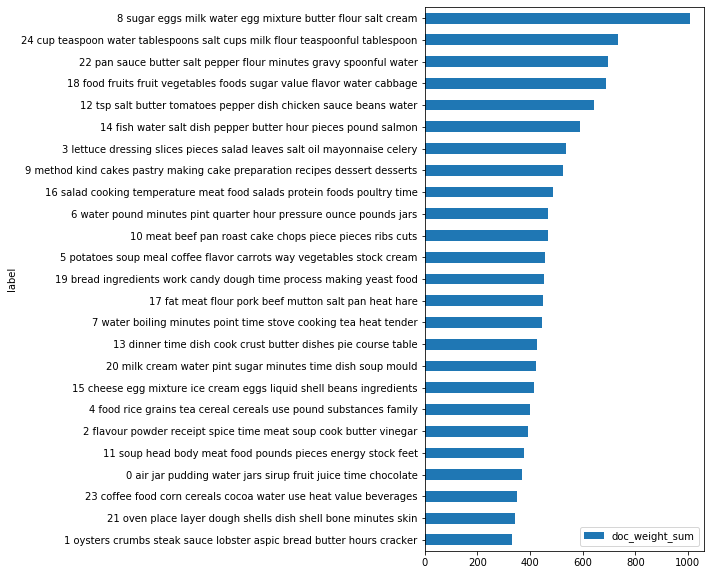

In [25]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,10));

## LIB Table

In [26]:
LIB

author_last                                      author_full  \
book_id                                                                
9935          WIDAS  Woman's Institute of Domestic Arts and Sciences   
9936          WIDAS  Woman's Institute of Domestic Arts and Sciences   
9937          WIDAS  Woman's Institute of Domestic Arts and Sciences   
9938          WIDAS  Woman's Institute of Domestic Arts and Sciences   
9939          WIDAS  Woman's Institute of Domestic Arts and Sciences   
10582       Bradley                                    Alice Bradley   
12519       Randolf                                    Mary Randolph   
15464       Goudiss                                    Alice Bradley   
19077          Hill                              Janet McKenzie Hill   
24205        Murrey                                 Thomas J. Murrey   
24542        Murrey                                 Thomas J. Murrey   
25007        Murrey                                 Thomas J. Murrey   
28681     Kitchiner                                William Kitchiner   
29519        Hooper                                      Mary Hooper   
32472          Lusk                                      Graham Lusk   
34107     Santiagoe                                 Daniel Santiagoe   
38464        Murrey                                 Thomas J. Murrey   
53521        Murrey                                 Thomas J. Murrey   
54568        Boland                                   Mary A. Boland   
61185         Payne                                 Arthur Gay Payne   

         book_year                                      book_title  \
book_id                                                              
9935          1923    Woman's Institute Library of Cookery, Vol. 1   
9936          1923    Woman's Institute Library of Cookery, Vol. 2   
9937          1923    Woman's Institute Library of Cookery, Vol. 3   
9938          1923    Woman's Institute Library of Cookery, Vol. 4   
9939          1923    Woman's Institute Library of Cookery, Vol. 5   
10582         1923                  For Luncheon and Supper Guests   
12519         1860                          The Virginia Housewife   
15464         1918     Foods That Will Win The War And How To Cook   
19077         1909  Salads, Sandwiches and Chafing - Dish Dainties   
24205         1885                              Breakfast Dainties   
24542         1885                                    Fifty Salads   
25007         1884                                     Fifty Soups   
28681         1830     The Cook's Oracle; and Housekeeper's Manual   
29519         1892                          Nelson's Home Comforts   
32472         1918                                Food in War Time   
34107         1887                      The Curry Cook's Assistant   
38464         1891                           Tempting Curry Dishes   
53521         1888                                Oysters and Fish   
54568         1893                   A Handbook of Invalid Cooking   
61185         1877                Common - Sense Papers on Cookery   

                                             book_file  
book_id                                                 
9935            Cookbooks/WIDAS1923_WILCV01_pg9935.txt  
9936            Cookbooks/WIDAS1923_WILCV02_pg9936.txt  
9937            Cookbooks/WIDAS1923_WILCV03_pg9937.txt  
9938            Cookbooks/WIDAS1923_WILCV04_pg9938.txt  
9939            Cookbooks/WIDAS1923_WILCV05_pg9939.txt  
10582           Cookbooks/Bradley1923_FLSG_pg10582.txt  
12519    Cookbooks/Randolf1860_VAHousewife_pg12519.txt  
15464            Cookbooks/Goudiss1918_War_pg15464.txt  
19077             Cookbooks/Hill1909_SSCDD_pg19077.txt  
24205           Cookbooks/Murrey1885_Bfast_pg24205.txt  
24542          Cookbooks/Murrey1885_Salads_pg24542.txt  
25007           Cookbooks/Murrey1884_Soups_pg25007.txt  
28681          Cookbooks/Kitchiner1830_TCO_pg28681.txt  
29519             Cookbooks

### Adding time period

In [27]:
# adding in a feature for the rough period of time
per = []
for i in range(0, len(LIB)):
    # creating three groups -- those after 1900, those in the late 1800s, and those in the mid 1800s
    # creating three groups -- those after 1920, those in the late 1800s, and those in the mid 1800s
    if LIB.book_year.iloc[i] >= 1900: 
        value = '1900s'
    elif LIB.book_year.iloc[i] >= 1875:
        value = "late-1800s"
    else:
        value = "mid-1800s"
    per.append(value)
LIB['period'] = per

In [28]:
# adding in a feature for the rough period of time
dec = []
for i in range(0, len(LIB)):
    # creating three groups -- those after 1920, those in the late 1800s, and those in the mid 1800s
    if LIB.book_year.iloc[i] >= 1920: 
        value = '1920s'
    elif LIB.book_year.iloc[i] >= 1910:
        value = "1910s"
    elif LIB.book_year.iloc[i] >= 1900:
        value = "1900s"
    elif LIB.book_year.iloc[i] >= 1890:
        value = "1890s"
    elif LIB.book_year.iloc[i] >= 1880:
        value = "1880s"  
    else:
        value = "pre-1880s"
    dec.append(value)
LIB['decade'] = dec

In [29]:
LIB.sort_values(['book_year'])

author_last                                      author_full  \
book_id                                                                
28681     Kitchiner                                William Kitchiner   
12519       Randolf                                    Mary Randolph   
61185         Payne                                 Arthur Gay Payne   
25007        Murrey                                 Thomas J. Murrey   
24542        Murrey                                 Thomas J. Murrey   
24205        Murrey                                 Thomas J. Murrey   
34107     Santiagoe                                 Daniel Santiagoe   
53521        Murrey                                 Thomas J. Murrey   
38464        Murrey                                 Thomas J. Murrey   
29519        Hooper                                      Mary Hooper   
54568        Boland                                   Mary A. Boland   
19077          Hill                              Janet McKenzie Hill   
15464       Goudiss                                    Alice Bradley   
32472          Lusk                                      Graham Lusk   
9939          WIDAS  Woman's Institute of Domestic Arts and Sciences   
9938          WIDAS  Woman's Institute of Domestic Arts and Sciences   
9937          WIDAS  Woman's Institute of Domestic Arts and Sciences   
9936          WIDAS  Woman's Institute of Domestic Arts and Sciences   
10582       Bradley                                    Alice Bradley   
9935          WIDAS  Woman's Institute of Domestic Arts and Sciences   

         book_year                                      book_title  \
book_id                                                              
28681         1830     The Cook's Oracle; and Housekeeper's Manual   
12519         1860                          The Virginia Housewife   
61185         1877                Common - Sense Papers on Cookery   
25007         1884                                     Fifty Soups   
24542         1885                                    Fifty Salads   
24205         1885                              Breakfast Dainties   
34107         1887                      The Curry Cook's Assistant   
53521         1888                                Oysters and Fish   
38464         1891                           Tempting Curry Dishes   
29519         1892                          Nelson's Home Comforts   
54568         1893                   A Handbook of Invalid Cooking   
19077         1909  Salads, Sandwiches and Chafing - Dish Dainties   
15464         1918     Foods That Will Win The War And How To Cook   
32472         1918                                Food in War Time   
9939          1923    Woman's Institute Library of Cookery, Vol. 5   
9938          1923    Woman's Institute Library of Cookery, Vol. 4   
9937          1923    Woman's Institute Library of Cookery, Vol. 3   
9936          1923    Woman's Institute Library of Cookery, Vol. 2   
10582         1923                  For Luncheon and Supper Guests   
9935          1923    Woman's Institute Library of Cookery, Vol. 1   

                                             book_file      period     decade  
book_id                                                                        
28681          Cookbooks/Kitchiner1830_TCO_pg28681.txt   mid-1800s  pre-1880s  
12519    Cookbooks/Randolf1860_VAHousewife_pg12519.txt   mid-1800s  pre-1880s  
61185             Cookbooks/Payne1877_CSPC_pg61185.txt  late-1800s  pre-1880s  
25007           Cookbooks/Murrey1884_Soups_pg25007.txt  late-1800s      1880s  
24542          Cookbooks/Murrey1885_Salads_pg24542.txt  late-1800s      1880s  
24205           Cookbooks/Murrey1885_Bfast_pg24205.txt  late-1800s      1880s  
34107        Cookbooks/Santiagoe1887_Curry_pg34107.txt  late-1800s      1880s  
53521            Cookbooks/Murrey1888_Fish_pg53521.txt  late-1800s      1880s  
38464           Cookbooks/Murrey1891_Curry_pg38464.txt  late-1800s      1890s  
29

## Explore Topics by Author

*see which topics correlate strongly with which author*

In [34]:
AUTHORS = get_Group(THETA, LIB, OHCO, TOPICS, n_topics=n_topics, name='author_last')

In [35]:
AUTHORS.sort_values('WIDAS', ascending=False).style.background_gradient()

## Plotly

* Q: how to correct if data is imbalanced?
* A: standardize bag; some only use paragraphs, others use evenly-sized chunks

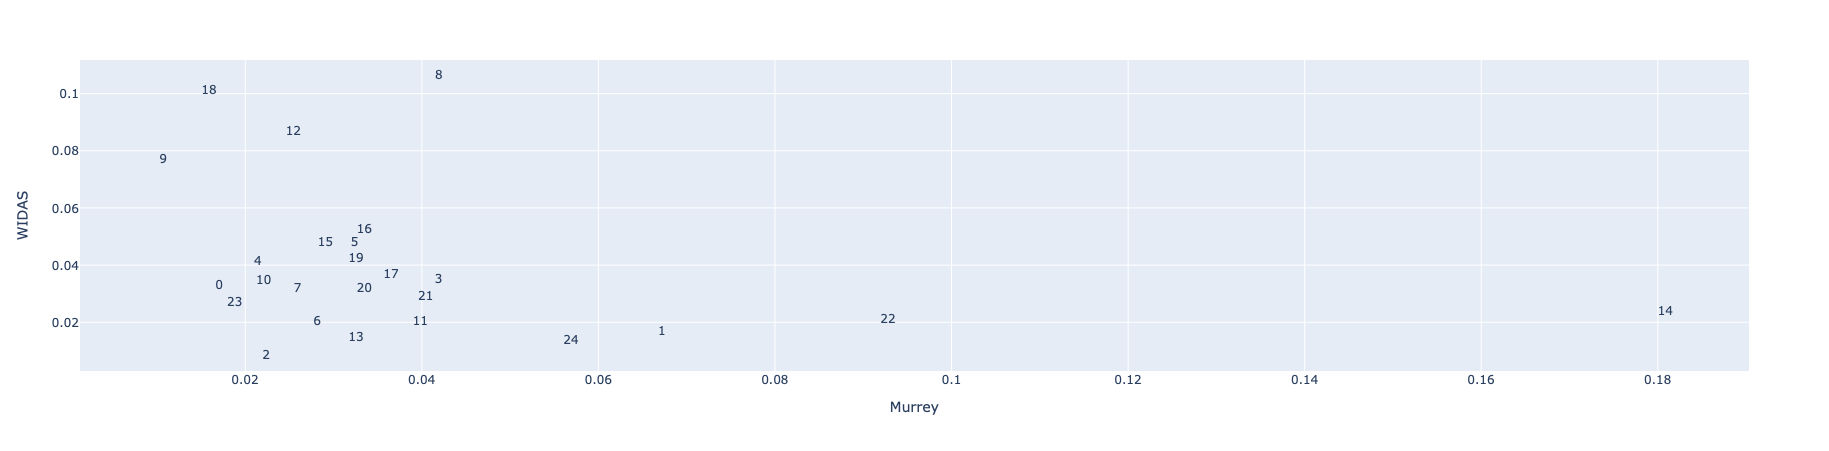

In [37]:
px.scatter(AUTHORS.reset_index(), 'Murrey', 'WIDAS', hover_name='topterms', text='topic_id')\
    .update_traces(mode='text')

---
## Explore Topics by Period

In [36]:
PERIOD = get_Group(THETA, LIB, OHCO, TOPICS, n_topics = n_topics, name='period')

In [38]:
PERIOD.sort_values('mid-1800s', ascending=False).style.background_gradient()

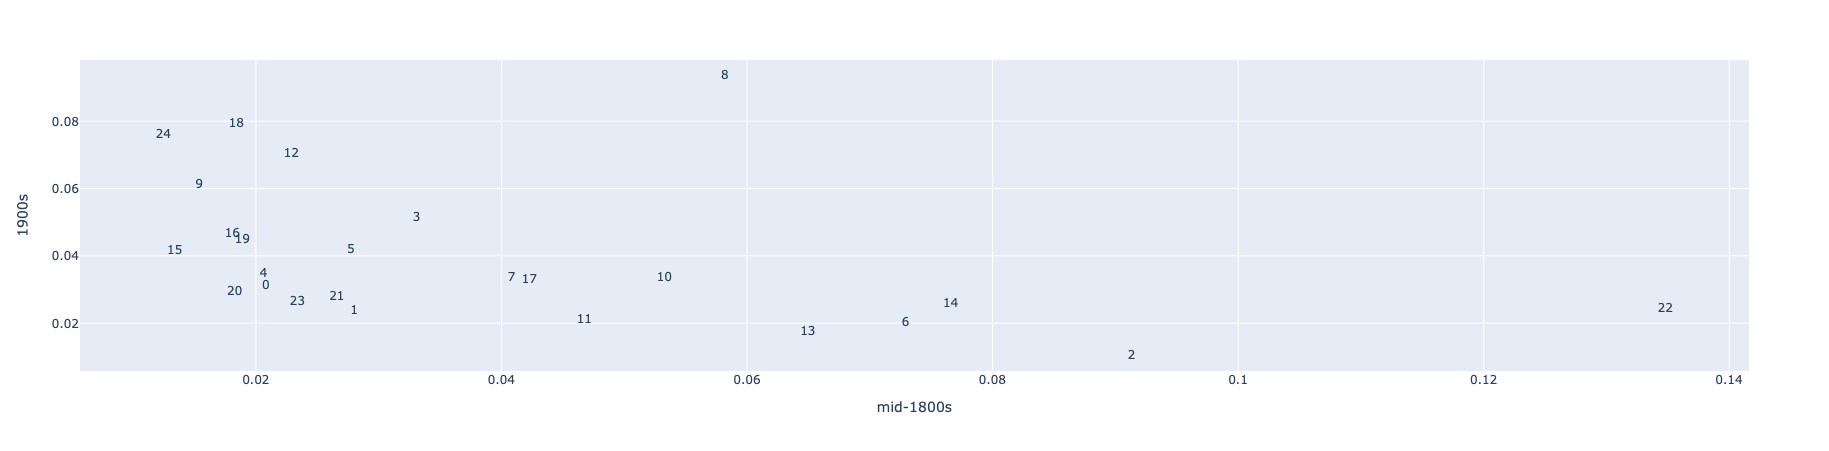

In [39]:
px.scatter(PERIOD.reset_index(), 'mid-1800s', '1900s', hover_name='topterms', text='topic_id')\
    .update_traces(mode='text')

---
## Explore Topics by Decade

In [40]:
DECADE = get_Group(THETA, LIB, OHCO, TOPICS, n_topics = n_topics, name='decade')

In [41]:
DECADE.sort_values('1920s', ascending=False).style.background_gradient()

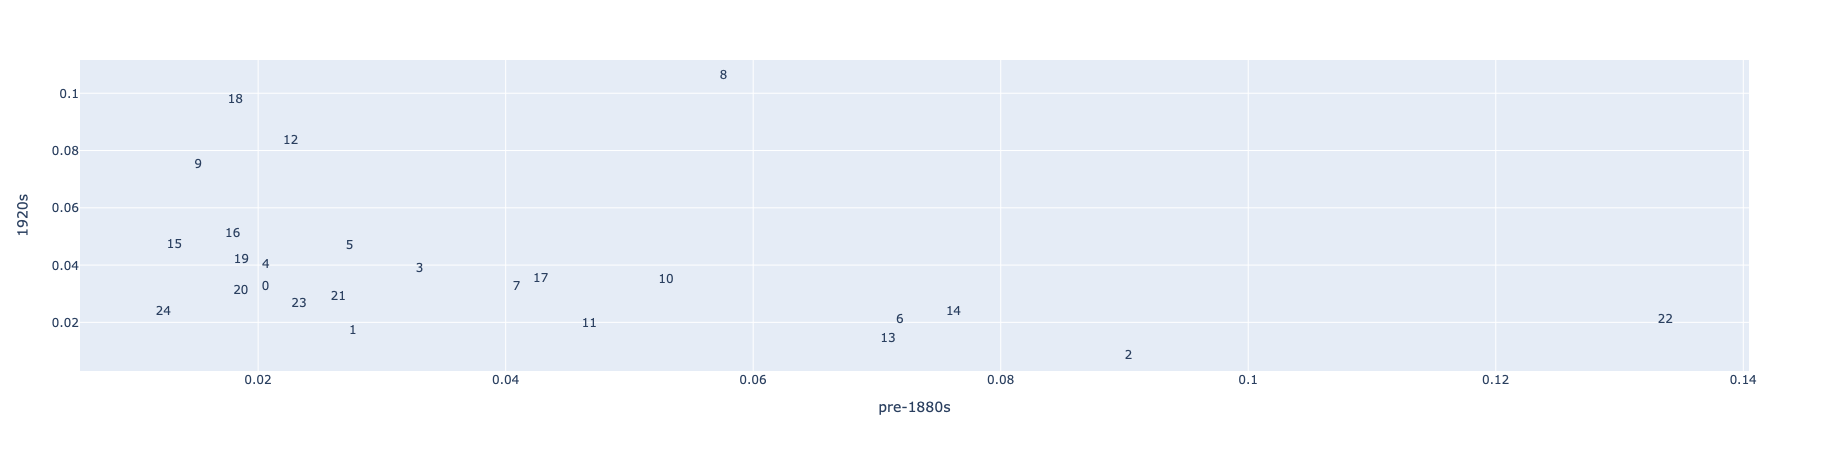

In [42]:
px.scatter(DECADE.reset_index(), 'pre-1880s', '1920s', hover_name='topterms', text='topic_id')\
    .update_traces(mode='text')

---
# Cluster Topics

*some of the topics that cluster closely might be the same*  
*can use this method to come up with more coherent topics*

<Figure size 432x288 with 0 Axes>

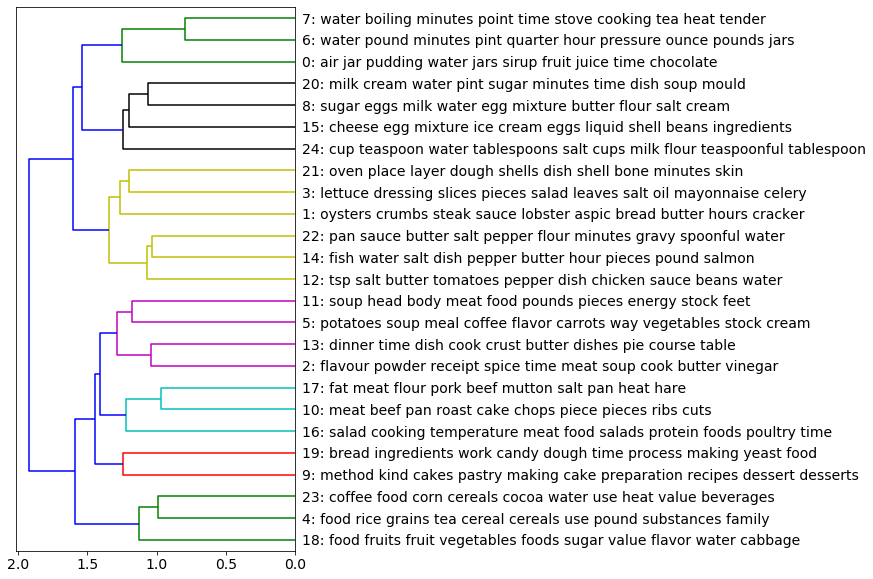

In [43]:
plot_tree(PHI, AUTHORS)

<Figure size 432x288 with 0 Axes>

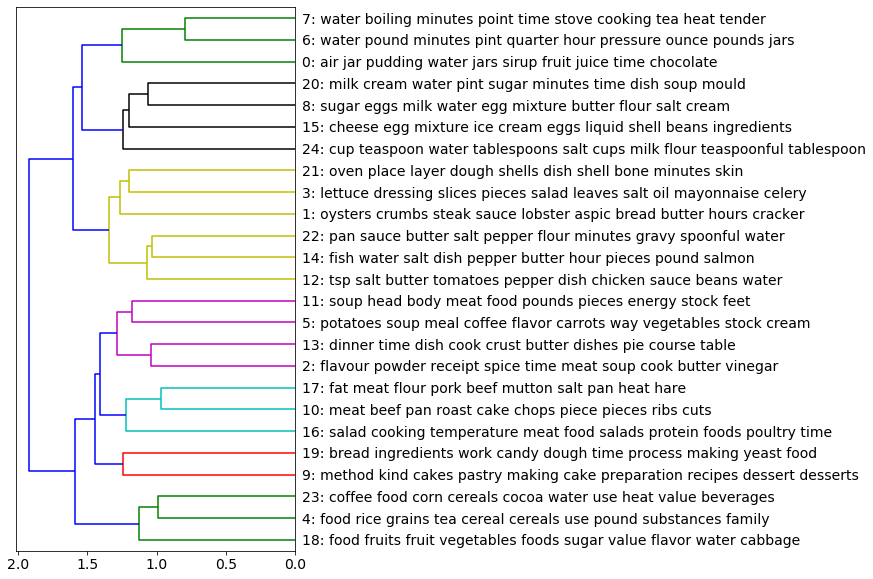

In [44]:
plot_tree(PHI, PERIOD)

<Figure size 432x288 with 0 Axes>

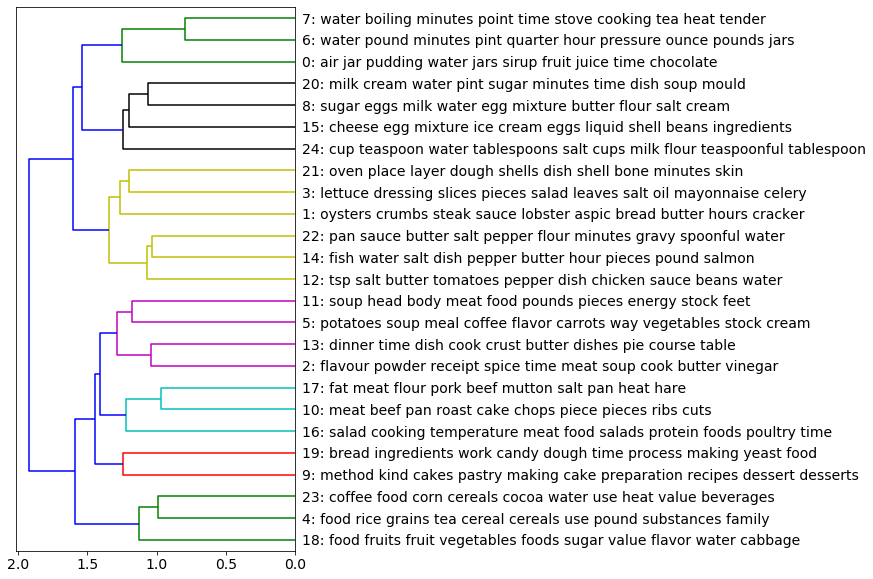

In [45]:
plot_tree(PHI, DECADE)

---
# LDA Viz


*Raf hasn't looked into relevance metric*  
*syndrome = common set of things*  
*Sid: common problem is you get different visual every time, even if you try to set seed*  
*Raf: this is something of a black box, not well-documented, doesn't have explanation*  
*Sid: if you evaluate LDA with coherence measure, can you use this to get number of topics to specify in model; but still doesn't feel he knows how to specify exactly*  
*Raf: I don't know how to select number either; you can define a threshold of similarity*

In [33]:
pyLDAvis.sklearn.prepare(lda, tf, tfv)

/Users/Kobresia/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.172244 -0.223054       1        1  8.572103
22    -0.248245  0.056307       2        1  6.059417
13     0.022321  0.133973       3        1  5.974558
14    -0.209424  0.098813       4        1  5.628054
18     0.214076 -0.083979       5        1  5.379202
24    -0.234550 -0.171278       6        1  5.357817
3     -0.155106  0.004150       7        1  4.511464
12    -0.063449 -0.012879       8        1  4.143124
6     -0.065573 -0.015571       9        1  4.018881
17     0.006877  0.104584      10        1  3.917973
9      0.208178 -0.144774      11        1  3.903076
7     -0.053384  0.034409      12        1  3.806614
16     0.198243  0.043329      13        1  3.736751
20    -0.039969 -0.091991      14        1  3.456682
10     0.041377  0.142788      15        1  3.236502
15     0.058005 -0.180656      16        1  3.225182
19     0.127107 -0.039261      17        1  3.202117
11     0.075754  0.194069      18        1  3.102934
4      0.165698  0.023423      19        1  3.070373
23     0.132237  0.056089      20        1  2.804129
5      0.111249 -0.020154      21        1  2.782583
2     -0.053960  0.129875      22        1  2.759746
21    -0.063189  0.024563      23        1  2.722646
0      0.108386 -0.108344      24        1  2.659867
1     -0.110414  0.045572      25        1  1.968206, topic_info=     Category         Freq      Term        Total  loglift  logprob
2766  Default  2480.000000      milk  2480.000000  30.0000  30.0000
1145  Default  1278.000000       cup  1278.000000  29.0000  29.0000
4868  Default  4641.000000     water  4641.000000  28.0000  28.0000
4427  Default  2268.000000     sugar  2268.000000  27.0000  27.0000
466   Default  1231.000000     bread  1231.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
4015  Topic25    23.894761     serve   412.764666   1.0788  -5.1953
4142  Topic25    24.367893    slices   746.401821   0.5060  -5.1757
3609  Topic25    23.380961  quantity   715.683125   0.5067  -5.2170
2518  Topic25    22.872114     lemon   441.959534   0.9667  -5.2390
2766  Topic25    22.975648      milk  2480.111588  -0.7536  -5.2345

[1810 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
12       11  0.798278  accompanying
20        1  0.004235          acid
20        3  0.016939          acid
20        5  0.203269          acid
20        9  0.156686          acid
...     ...       ...           ...
4992     16  0.037477         yolks
4992     25  0.014991         yolks
4993     18  0.127611     yorkshire
4993     24  0.765665     yorkshire
4996     12  0.869455            yr

[7803 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 23, 14, 15, 19, 25, 4, 13, 7, 18, 10, 8, 17, 21, 11, 16, 20, 12, 5, 24, 6, 3, 22, 1, 2])